In [1]:
SEED = 42

Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [3]:
!pip install livelossplot -q

# Imports

In [4]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
import pandas as pd
import os
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass

Number of available GPUs: 1


# Paths

In [5]:
SRC_DIR = Path('/content/drive/MyDrive/TAI/III/nlp/')
DATA_DIR = SRC_DIR / "data"
LOG_DIR = SRC_DIR / 'logs'
BEST_MODEL_DIR = LOG_DIR / "checkpoints"
TENSOR_BOARD_DIR = LOG_DIR / "tensor_board"

# Dataset

## Load dataset

In [6]:
dataset_df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

## Dataset info

In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105354 entries, 0 to 105353
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               105354 non-null  int64 
 1   followers_count  105354 non-null  int64 
 2   verified         105354 non-null  bool  
 3   reactions_count  105354 non-null  int64 
 4   retweet_count    105354 non-null  int64 
 5   text             105354 non-null  object
 6   source           105354 non-null  object
 7   description      89892 non-null   object
 8   replies_count    105354 non-null  int64 
 9   fake             105354 non-null  bool  
dtypes: bool(2), int64(5), object(3)
memory usage: 6.6+ MB


In [8]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True


In [9]:
dataset_df['fake'].value_counts()

False    72229
True     33125
Name: fake, dtype: int64

Duplicates and NaNs

In [10]:
dataset_df.duplicated().sum()

0

In [11]:
dataset_df.isnull().sum()

id                     0
followers_count        0
verified               0
reactions_count        0
retweet_count          0
text                   0
source                 0
description        15462
replies_count          0
fake                   0
dtype: int64

## Clean data

### Drop NaNs

In [12]:
dataset_df = df = dataset_df.fillna('')

## Map type to int

In [13]:
mapping = {False: 0, True: 1}
dataset_df['class'] = dataset_df['fake']
dataset_df = dataset_df.replace({'class': mapping})

## Merge title and text

In [14]:
# dataset_df = dataset_df.astype(str)

In [15]:
dataset_df['text_combined'] = dataset_df[['text','description']].agg(' '.join, axis=1)
# dataset_df['text_combined'] = dataset_df[['followers_count', 'verified','reactions_count', 'retweet_count','text', 'source','description', 'replies_count']].agg(' '.join, axis=1)

In [16]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake,class,text_combined
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,Michael Brown is the 17 yr old boy who was sho...
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid And how long before a...
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True,1,@d_m_elms @AmeenaGK they'll drag his entire hi...
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,@d_m_elms @jaythenerdkid or traces back some b...
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...


## Split dataset to train, val and test

Function

In [17]:
from sklearn.model_selection import train_test_split

# separate data into data and labels
features = dataset_df['id']
targets = dataset_df['class'].astype(int)

# splitting data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=SEED)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=SEED)


In [18]:
predicted_frame = pd.DataFrame(X_test)
predicted_frame['index_column'] = predicted_frame.index
predicted_frame

,id,index_column
82242,552838808580808706,82242
5442,500365642432647170,5442
65369,544417180717043712,65369
11846,525031555186425856,11846
19284,544374437491904512,19284
...,...,...
97817,553522026548191232,97817
63413,544419721127284736,63413
68755,544485667166646272,68755
10329,524976972557189120,10329


In [19]:
print(len(dataset_df.loc[X_train.index]))
print(len(y_train))

84283
84283


### Convert X, y to tensors

In [20]:
X_train_text = tf.constant(dataset_df.loc[X_train.index]['text_combined'].to_list(), dtype=tf.string)
X_val_text = tf.constant(dataset_df.loc[X_val.index]['text_combined'].to_list(), dtype=tf.string)
X_test_text = tf.constant(dataset_df.loc[X_test.index]['text_combined'].to_list(), dtype=tf.string)

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
features_df = dataset_df[['followers_count', 'verified','reactions_count', 'retweet_count', 'replies_count']]
features_df = pd.DataFrame(scaler.fit_transform(features_df))

X_train_features = tf.constant(features_df.loc[X_train.index], dtype='float32')
X_val_features = tf.constant(features_df.loc[X_val.index], dtype='float32')
X_test_features = tf.constant(features_df.loc[X_test.index], dtype='float32')

In [22]:
# X_train =  tf.constant(X_train, dtype=tf.string)
# X_test =  tf.constant(X_test, dtype=tf.string)
# X_val =  tf.constant(X_val, dtype=tf.string)


In [23]:
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')

In [24]:
X_train_features.shape

TensorShape([84283, 5])

# Model

## Parameters

In [25]:
BATCH_SIZE = 64
EPOCHS = 100
VOCABULARY_SIZE = 100000
MAX_SEQUENCE_LEN = 300
EMBEDDING_DIM = 75

## Vectorization layer

In [26]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize='lower',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(X_train_text, batch_size=BATCH_SIZE)

## Model architecture

In [27]:
def lstm_model(num_stat_features):

    text_input = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
    stat_input = tf.keras.layers.Input(shape=(num_stat_features,), dtype=tf.float32)

    x = vectorize_layer(text_input)
    x = tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x)

    # x2 = tf.keras.layers.Dense(64, activation='relu')(stat_input)
    model_ = tf.keras.layers.concatenate([x, stat_input], axis=1)
    # model_ = tf.keras.layers.Dense(64, activation='relu')(model_)
    model_ = tf.keras.layers.Dense(32, activation='relu')(model_)
    model_pred = tf.keras.layers.Dense(1, activation='sigmoid')(model_)

    model_1 = tf.keras.Model(inputs=[text_input, stat_input], outputs=[model_pred])

    return model_1
model = lstm_model(5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 300)         0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 300, 75)      7500000     ['text_vectorization[0][0]']     
                                                                                                  
 bidirectional (Bidirectional)  (None, 256)          208896      ['embedding[0][0]']          

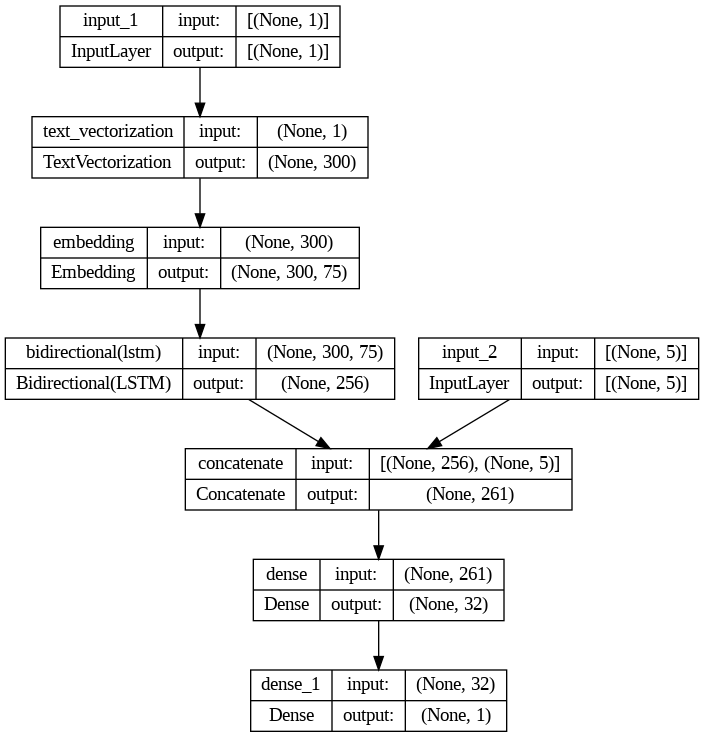

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.predict([X_test_text, X_test_features])

330/330 [==============================] - 8s 9ms/step


array([[0.4985659 ],
       [0.4996405 ],
       [0.3881809 ],
       ...,
       [0.4983725 ],
       [0.499821  ],
       [0.49886188]], dtype=float32)

## Metrics

In [30]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
    ]

## Compile

In [31]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics= METRICS
)

## Callbacks

In [32]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "lstm_with_auxiliary_input"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.001, restore_best_weights=True)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=LOG_DIR / "history_lstm_with_auxiliary_input.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

## Train

In [33]:
history = model.fit(
    [X_train_text, X_train_features], y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_text, X_val_features], y_val),
    callbacks=[save_best, early_stop, csv_logger],
    )

Epoch 1/100
1316/1317 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8535 - recall: 0.7174 - precision: 0.7962 - auc: 0.9212

1317/1317 [==============================] - 117s 84ms/step - loss: 0.3258 - accuracy: 0.8535 - recall: 0.7175 - precision: 0.7962 - auc: 0.9213 - val_loss: 0.2596 - val_accuracy: 0.8868 - val_recall: 0.8332 - val_precision: 0.8145 - val_auc: 0.9539
Epoch 2/100
1317/1317 [==============================] - 48s 36ms/step - loss: 0.1538 - accuracy: 0.9330 - recall: 0.8988 - precision: 0.8892 - auc: 0.9831 - val_loss: 0.2713 - val_accuracy: 0.8927 - val_recall: 0.7998 - val_precision: 0.8533 - val_auc: 0.9569
Epoch 3/100
1317/1317 [==============================] - 46s 35ms/step - loss: 0.0828 - accuracy: 0.9648 - recall: 0.9472 - precision: 0.9413 - auc: 0.9949 - val_loss: 0.3092 - val_accuracy: 0.8851 - val_recall: 0.7741 - val_precision: 0.8506 - val_auc: 0.9520
Epoch 4/100
1317/1317 [==============================] - 45s 34ms/step - loss: 0.0475 - accuracy: 0.9803 - recall: 0.9703 - precision: 0.9670 - auc: 0.9982 - val_loss: 0.3763 - val_accuracy: 0.8852 - val_recall: 0.8219 - val_pre

## Plot metrics history

In [34]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric_names):
  for n, metric in enumerate(metric_names):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



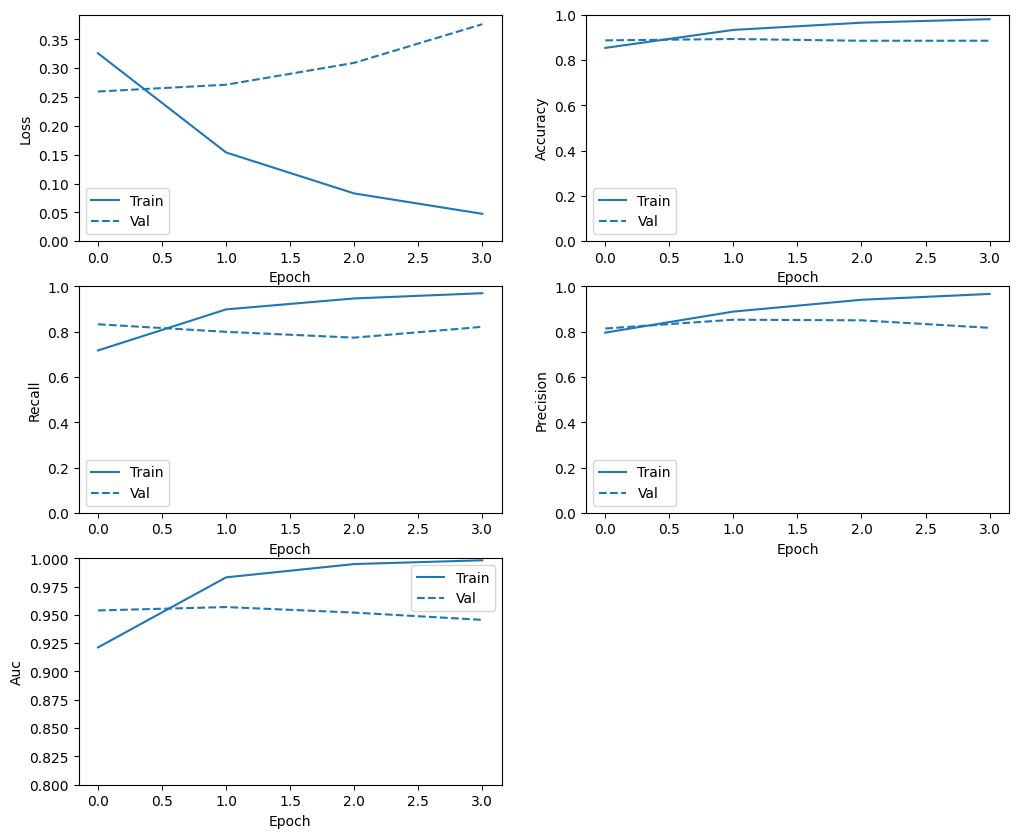

In [35]:
metrics = ["loss", 'accuracy', 'recall', 'precision', 'auc']
plt.figure(figsize=(12,10))
plot_metrics(history, metrics)

# Evaluation

In [36]:
model.evaluate([X_test_text, X_test_features], y_test)

330/330 [==============================] - 4s 11ms/step - loss: 0.2458 - accuracy: 0.8875 - recall: 0.8358 - precision: 0.8104 - auc: 0.9564


[0.24580320715904236,
 0.8875178098678589,
 0.8357619643211365,
 0.8104209303855896,
 0.9564001560211182]

In [38]:
preds = model.predict([X_test_text, X_test_features])

330/330 [==============================] - 7s 14ms/step


In [55]:
predicted_frame['preds'] = preds
predicted_frame['true'] = y_test
predicted_frame.columns
predicted_frame.drop(columns='id', inplace=True)
predicted_frame.to_csv('/content/drive/MyDrive/TAI/III/nlp/preds_dataframes/lstm_with_auxiliary_input.csv')
predicted_frame

,index_column,preds,true
82242,82242,0.020678,0.0
5442,5442,0.328958,1.0
65369,65369,0.220163,0.0
11846,11846,0.868251,1.0
19284,19284,0.942350,1.0
...,...,...,...
97817,97817,0.001324,0.0
63413,63413,0.014240,0.0
68755,68755,0.000022,0.0
10329,10329,0.834236,1.0
